In [0]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
image_path = "/content/drive/My Drive/best_boi-stanford-581.jpg"

In [0]:
def distord(image, k1, k2, p1, p2, x_center, y_center, x_focal, y_focal):
  width  = image.shape[1]
  height = image.shape[0]

  distCoeff = np.zeros((4,1),np.float64)

  # # TODO: add your coefficients here!
  # k1 = 1.0e-5; # negative to remove barrel distortion
  # k2 = 1.0e-5;
  # p1 = 0.0;
  # p2 = 0.0;

  distCoeff[0,0] = k1;
  distCoeff[1,0] = k2;
  distCoeff[2,0] = p1;
  distCoeff[3,0] = p2;

  # assume unit matrix for camera
  cam = np.eye(3,dtype=np.float32)

  cam[0,2] = x_center  # define center x
  cam[1,2] = y_center # define center y
  cam[0,0] = x_focal        # define focal length x
  cam[1,1] = y_focal    # define focal length y

  # here the undistortion will be computed
  dst = cv2.undistort(image,cam,distCoeff)

  return dst

In [0]:
def makeBoundingBox(h,w, step):
    #BBox is 100*100 square or step which is defied
    y = 0
    bbox = []
    while y < h:
        #print("Y value", y)
        x=0
        while x < w:
            #print("X Value", x)
            bbox.append([(x,y), (x+step, y+step)])
            x += step
        y += step

    return bbox

In [0]:
def drawBasicGrid(image, pxstep):
    x = pxstep
    y = pxstep
    #Draw all x lines
    while x < image.shape[1]:
        cv2.line(image, (x, 0), (x, image.shape[0]), color=(255, 0, 255), thickness=1)
        x += pxstep

    while y < image.shape[0]:
        cv2.line(image, (0, y), (image.shape[1], y), color=(255, 0, 255),thickness=1)
        y += pxstep

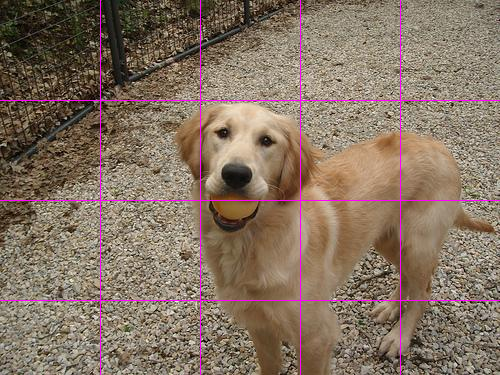

In [0]:
#Prepare Images
img = cv2.imread(image_path)
#img = imutils.resize(img, width=300)
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
(H,W) = img.shape[:2]

#Visual grid drawn
drawBasicGrid(img, 100)

cv2_imshow(img)

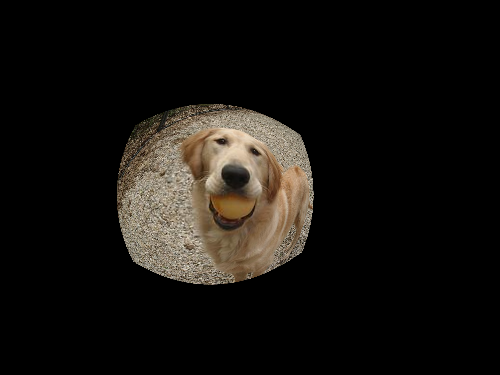

In [0]:
image = cv2.imread(image_path)

image_distord = distord(image, 1.0e-5, 1.0e-5, 0, 0, 210, 195, 5, 5)

cv2_imshow(image_distord)

In [0]:
dog_cascade = cv2.CascadeClassifier('/content/drive/My Drive/raw_data/meme_breeds/data/cascade.xml')

In [0]:
def process_image(img):
    img_output = img.copy()

    # convery to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # this function returns tuple rectangle starting coordinates x,y, width, height
    dogs = dog_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=6)
    #print(cats_ext)
    
    # draw a blue rectangle on the image
    for (x,y,w,h) in dogs:
        img_output = cv2.rectangle(img_output,(x,y),(x+w,y+h),(255,0,0),2)       
    
    return img_output

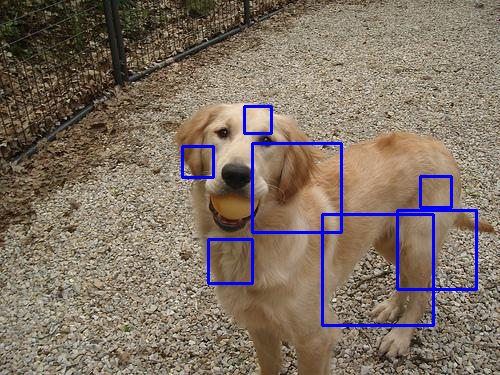

In [0]:
test = process_image(image)

cv2_imshow(test)

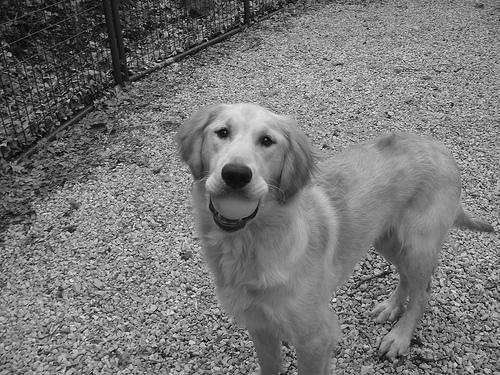

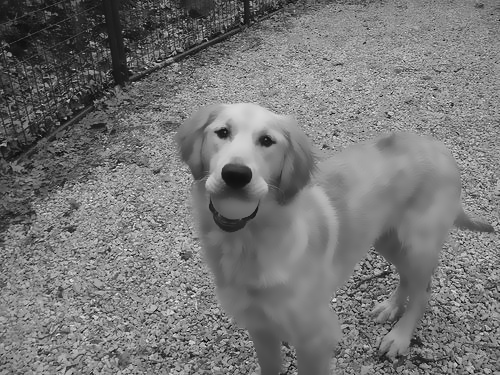

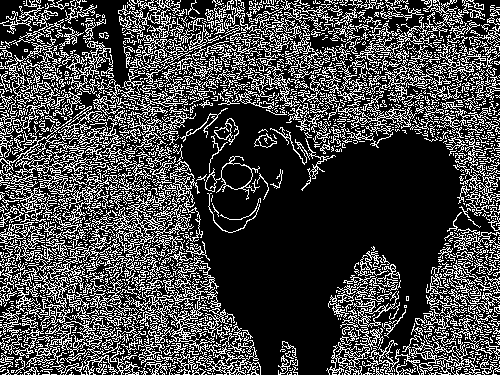

In [0]:
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
cv2_imshow(gray)
edged = cv2.Canny(gray, 30, 200)
cv2_imshow(edged)


In [0]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage import io

In [0]:
def segment_colorfulness(image, mask):
	# split the image into its respective RGB components, then mask
	# each of the individual RGB channels so we can compute
	# statistics only for the masked region
	(B, G, R) = cv2.split(image.astype("float"))
	R = np.ma.masked_array(R, mask=mask)
	G = np.ma.masked_array(B, mask=mask)
	B = np.ma.masked_array(B, mask=mask)
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`,
	# then combine them
	stdRoot = np.sqrt((rg.std() ** 2) + (yb.std() ** 2))
	meanRoot = np.sqrt((rg.mean() ** 2) + (yb.mean() ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)
	

In [0]:
orig = cv2.imread("/content/drive/My Drive/dog_pic1.jpg")
orig = cv2.GaussianBlur(orig,(5,5),cv2.BORDER_DEFAULT)

vis = np.zeros(orig.shape[:2], dtype="float")


segments = slic(img_as_float(image), 100,
	slic_zero=True)

error: ignored

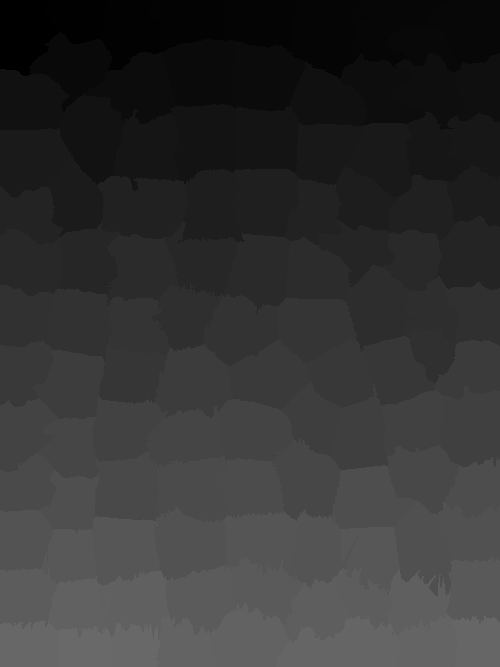

In [0]:
cv2_imshow(segments)

In [0]:
# loop over each of the unique superpixels
for v in np.unique(segments):
	# construct a mask for the segment so we can compute image
	# statistics for *only* the masked region
	mask = np.ones(image.shape[:2])
	mask[segments == v] = 0
	# compute the superpixel colorfulness, then update the
	# visualization array
	C = segment_colorfulness(orig, mask)
	vis[segments == v] = C


In [0]:
# scale the visualization image from an unrestricted floating point
# to unsigned 8-bit integer array so we can use it with OpenCV and
# display it to our screen
vis = rescale_intensity(vis, out_range=(0, 255)).astype("uint8")
# overlay the superpixel colorfulness visualization on the original
# image
alpha = 0.6
overlay = np.dstack([vis] * 3)
output = orig.copy()
cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

array([[[113, 128, 129],
        [113, 128, 129],
        [112, 127, 129],
        ...,
        [ 82,  86,  90],
        [ 82,  86,  90],
        [ 82,  86,  90]],

       [[113, 128, 129],
        [113, 128, 129],
        [112, 127, 129],
        ...,
        [ 82,  86,  90],
        [ 82,  86,  90],
        [ 82,  86,  90]],

       [[113, 129, 130],
        [113, 128, 129],
        [112, 128, 129],
        ...,
        [ 82,  86,  90],
        [ 82,  86,  90],
        [ 82,  86,  90]],

       ...,

       [[ 79, 109, 108],
        [ 79, 109, 108],
        [ 78, 108, 107],
        ...,
        [ 69,  99,  94],
        [ 69, 100,  95],
        [ 69, 100,  95]],

       [[ 79, 109, 108],
        [ 79, 109, 108],
        [ 79, 108, 107],
        ...,
        [ 69,  99,  94],
        [ 69, 100,  95],
        [ 69, 100,  95]],

       [[ 80, 109, 108],
        [ 80, 109, 108],
        [ 79, 109, 108],
        ...,
        [ 69,  99,  94],
        [ 69, 100,  95],
        [ 69, 100,  95]]

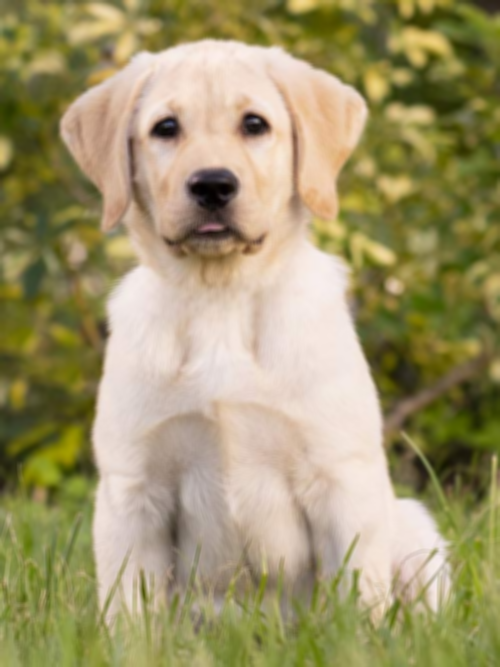

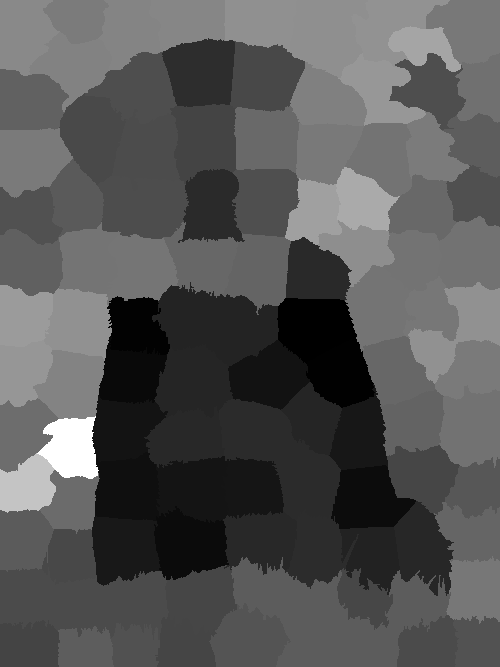

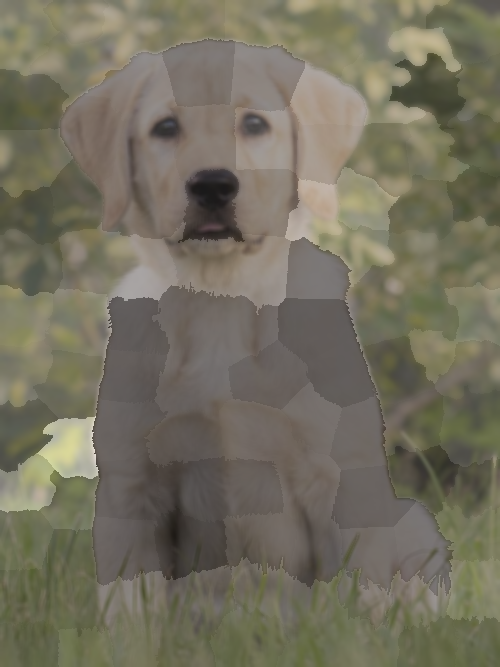

In [0]:
cv2_imshow(orig)
cv2_imshow(vis)
cv2_imshow(output)

# Part 1 : Nose Segmentation

In [0]:
from skimage import data, util
from skimage.measure import label, regionprops
from skimage import io; 
io.use_plugin('matplotlib')

In [0]:
image = cv2.imread("/content/drive/My Drive/best_boi-stanford-581.jpg")

In [0]:
def super_pixel(image, n_segments, sigma):
  image_slic = slic(image, n_segments=n_segments, sigma=sigma)
  return image_slic

In [0]:
def preprocess(image, image_slic, n_regions):
  try:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  except:
    print("Can't convert image to gray, maybe it's already gray")
    gray = image

  vis = np.zeros(gray.shape[:2], dtype="float")

  df_regions_infos = regions_infos(image_slic)

  # We loop over each unique superpixel
  for v in np.unique(image_slic):
    # Create a mask for this segment
    mask = np.ones(gray.shape[:2])
    mask[image_slic==v] = 0

    # Compute the mean darkness
    d = segment_darkness(gray, mask)
    vis[image_slic==v] = d

    df_regions_infos.loc[v, 'darkness'] = d

  vis_bbox = vis.astype("uint8")
  vis_bbox = cv2.cvtColor(vis_bbox, cv2.COLOR_GRAY2RGB)
  
  df_regions_infos.sort_values(by='darkness', ascending=True, inplace=True)
  print(df_regions_infos.head(n_regions))
  for index, row in df_regions_infos.head(n_regions).iterrows():
    try:
      print(row['bbox'])
      y_min, x_min, y_max, x_max = row['bbox']
      cv2.rectangle(vis_bbox, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    except TypeError:
      pass

  cv2_imshow(vis_bbox)

  return vis.astype("uint8"), df_regions_infos

In [0]:
def segment_darkness(image, mask):
	image_masked = np.ma.masked_array(image, mask=mask)
	d = image_masked.mean()
	return d

In [0]:
def regions_bbox(labels):
  regions = regionprops(labels)
  bbox_dict = {}
  for region in regions:
    bbox_dict[region.label] = list(region.bbox)
  return bbox_dict

def regions_infos(labels):
  regions = regionprops(labels)
  df = pd.DataFrame({'bbox' : [list(region.bbox) for region in regions],
                     'centroid' : [list(region.centroid) for region in regions]
                     },
                         index = [region.label for region in regions])
  return df

                    bbox                                  centroid    darkness
0                    NaN                                       NaN   37.211977
2       [0, 84, 49, 131]   [22.10443864229765, 106.66997389033942]   43.469974
1        [0, 42, 47, 88]     [21.80092831356369, 64.0670448684889]   43.717896
20       [43, 0, 86, 47]                [63.5, 21.672619047619047]   55.643398
16     [41, 84, 91, 135]   [65.64772087788407, 108.88294879009567]   57.387169
..                   ...                                       ...         ...
53  [170, 342, 213, 384]  [191.52988505747126, 362.10459770114943]  145.479310
23    [44, 385, 88, 426]   [65.42074592074592, 404.65617715617714]  146.379953
47  [130, 385, 174, 427]   [151.16636744464392, 404.8144823459007]  146.567325
34   [87, 344, 130, 386]   [108.24885583524028, 363.8987414187643]  148.794050
41  [127, 423, 173, 463]   [149.09620098039215, 443.2873774509804]  149.926471

[100 rows x 3 columns]
nan
[0, 84, 49, 131]
[0, 42,

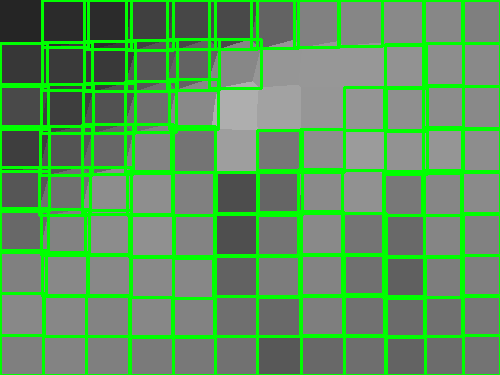

(array([[ 37,  37,  37, ..., 127, 127, 127],
        [ 37,  37,  37, ..., 127, 127, 127],
        [ 37,  37,  37, ..., 127, 127, 127],
        ...,
        [127, 127, 127, ..., 115, 115, 115],
        [127, 127, 127, ..., 115, 115, 115],
        [127, 127, 127, ..., 115, 115, 115]], dtype=uint8),
                     bbox                                  centroid    darkness
 0                    NaN                                       NaN   37.211977
 2       [0, 84, 49, 131]   [22.10443864229765, 106.66997389033942]   43.469974
 1        [0, 42, 47, 88]     [21.80092831356369, 64.0670448684889]   43.717896
 20       [43, 0, 86, 47]                [63.5, 21.672619047619047]   55.643398
 16     [41, 84, 91, 135]   [65.64772087788407, 108.88294879009567]   57.387169
 ..                   ...                                       ...         ...
 19    [42, 344, 88, 386]   [65.28315612758814, 364.46558477895917]  151.678791
 46  [130, 343, 173, 386]   [150.2572759022119, 364.4051222351

In [0]:
preprocess(img, super_pixel(img, 100, 50), 100)

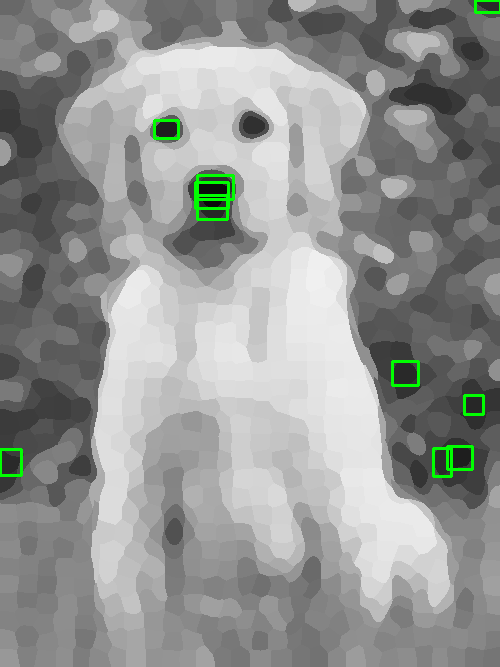

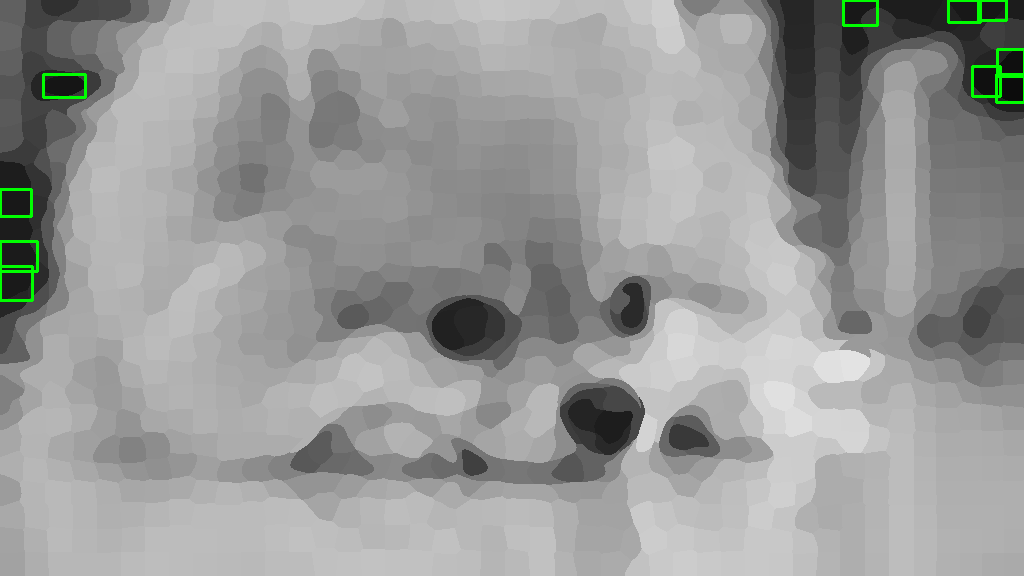

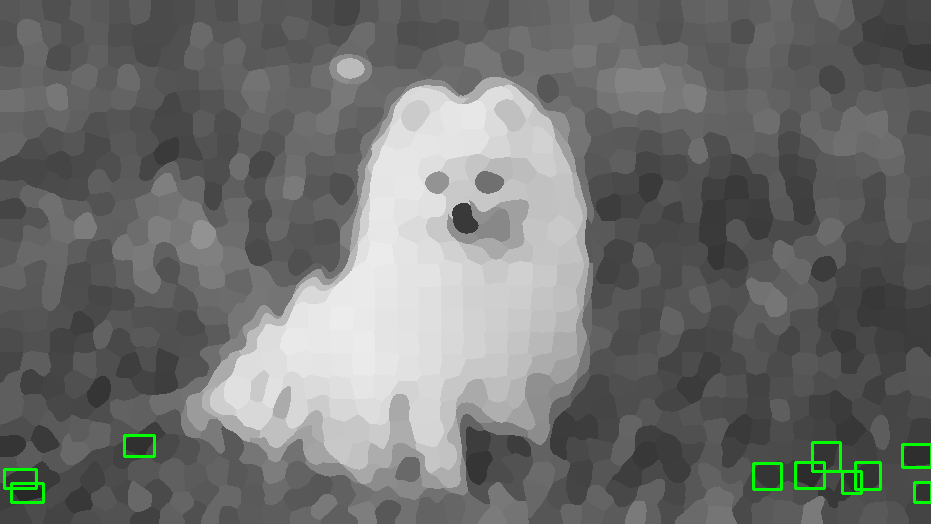

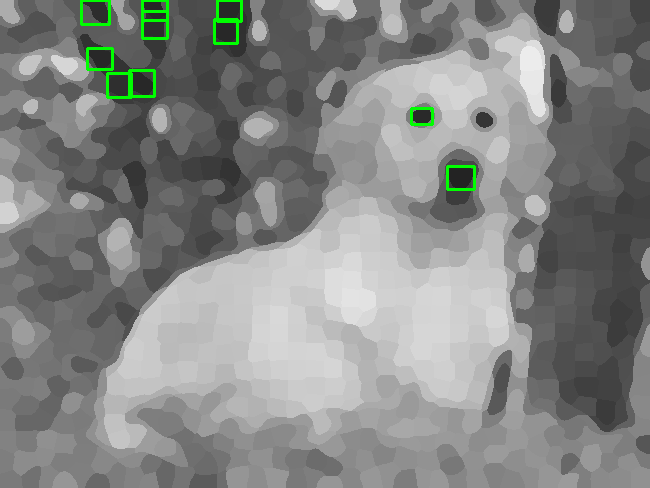

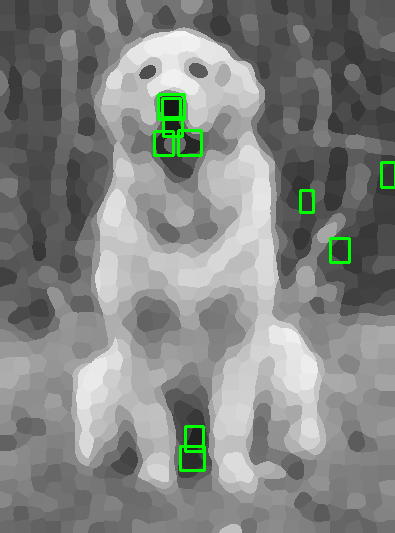

In [0]:
for i in range(1, 6):
  image = cv2.imread("/content/drive/My Drive/dog_pic{}.jpg".format(i))
  preprocess(image, super_pixel(image, 1000, 5), 10)

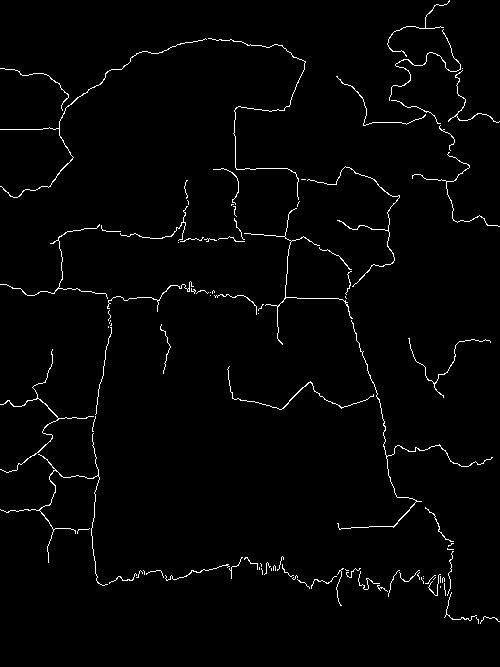

In [0]:
edge_detected_image = cv2.Canny(vis, 75, 200)
cv2_imshow(edge_detected_image)

In [0]:
# for i in range(1, 6):
#   image = cv2.imread("/content/drive/My Drive/dog_pic{}.jpg".format(i))
#   preprocess(image, super_pixel(image, 5000, 9))

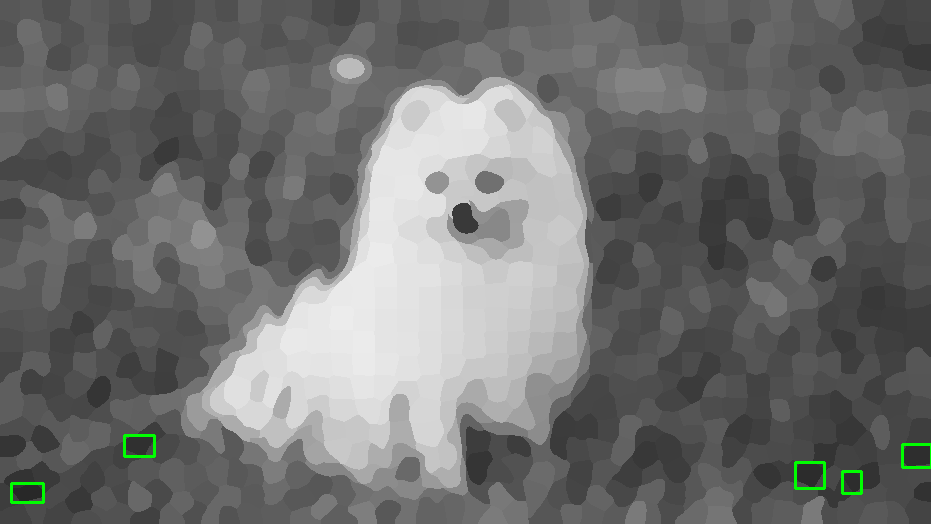

Can't convert image to gray, maybe it's already gray


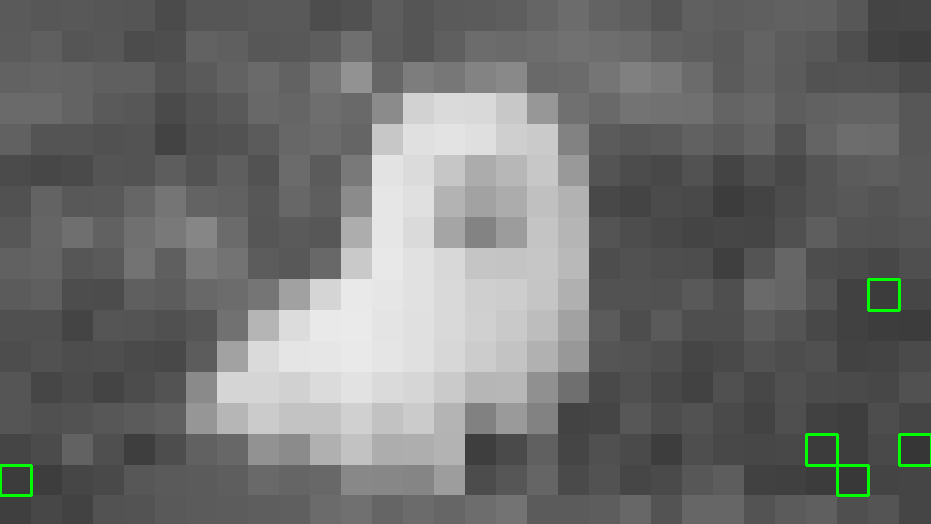

In [0]:
image = cv2.imread("/content/drive/My Drive/dog_pic3.jpg")
image2, df2 = preprocess(image, super_pixel(image, 1000, 5), 5)
image3, df3 = preprocess(image2, super_pixel(image2, 500, 1), 5)

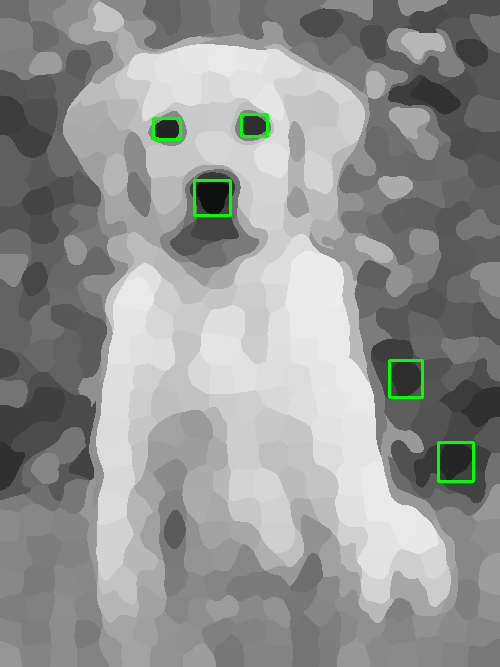

In [0]:
image = cv2.imread("/content/drive/My Drive/dog_pic1.jpg")
image_slic = super_pixel(image, 500, 5)
dog1, df = preprocess(image, image_slic, 5)

In [0]:
print(df['centroid'])

134    [195.05889014722536, 211.95583238958096]
90     [128.72413793103448, 166.48275862068965]
316     [459.06702702702705, 454.1372972972973]
259     [377.6277712952159, 405.36872812135357]
88      [124.99771167048056, 252.8421052631579]
                         ...                   
256      [375.9960053262317, 348.5659121171771]
204      [296.39102564102564, 299.425641025641]
182      [267.1949860724234, 303.5807799442897]
185    [270.83125864453666, 327.90594744121717]
210     [296.8288770053476, 327.17245989304814]
Name: centroid, Length: 467, dtype: object


In [0]:
def distance(A, B):
  # A should be [xA, yA], and B [xB, yB]
  return np.sqrt((A[0]-B[0])**2+(A[1]-B[1])**2)  

In [0]:
# def divide_and_conquer_closest_pair(values):
#   # O(nlogn)
#   if len(values)<=1:
#     return None
#   elif len(values)==2:
#     return abs(values[0] - values[1])
#   else:
#     sep = int(len(values)/2)
#     right_values = values[:sep]
#     left_values = values[sep:]
#     # print("Testing on right : {}".format(right_values))
#     min_right_values = divide_and_conquer_closest_pair(right_values)
#     # print("Testing on left : {}".format(left_values))
#     min_left_values = divide_and_conquer_closest_pair(left_values)
#     try:
#       # print("Testing on middle : {}".format([values[sep-1], values[sep]]))
#       middle_values = divide_and_conquer_closest_pair([values[sep-1], values[sep]])
#     except:
#       middle_values = None
#     return(min(min_right_values,
#                min_left_values,
#                middle_values))

def divide_and_conquer_closest_pair(serie):
  # O(nlogn)
  if serie.size<=1:
    return None
  elif serie.size==2:
    sub = abs(serie.values.tolist()[0] - serie.values.tolist()[1])
    return sub, [serie.index[0], serie.index[1]], sub/max([serie.index[0], serie.index[1]])
  else:
    sep = int(serie.size/2)
    right_values = serie.iloc[:sep]
    left_values = serie.iloc[sep:]

    # print("---> Testing on right : \n{}".format(right_values))
    min_right_values, min_right_values_index, min_right_values_ratio = divide_and_conquer_closest_pair(right_values)
    # print("---> Testing on left : \n{}".format(left_values))
    min_left_values, min_left_values_index, min_left_values_ratio = divide_and_conquer_closest_pair(left_values)
    # print("---> Testing on middle : \n{}".format(serie.iloc[sep-1:sep+1]))
    middle_values, middle_values_index, middle_values_ratio = divide_and_conquer_closest_pair(serie.iloc[sep-1:sep+1])

    values = [min_right_values, min_left_values, middle_values]
    values_index = [min_right_values_index, min_left_values_index, middle_values_index]
    values_ratio = [min_right_values_ratio, min_left_values_ratio, middle_values_ratio]
    
    return(min(values), values_index[values.index(min(values))], values_ratio[values.index(min(values))])

In [0]:
from itertools import combinations
from sklearn.metrics.pairwise import euclidean_distances
import scipy

def find_isoceles(df, threshold):
  df_coord = pd.DataFrame(df['centroid'].values.tolist(), columns=['centroid_x','centroid_y'], index=df.index)
  distances = pd.DataFrame(scipy.spatial.distance.cdist(df_coord.iloc[:,1:], df_coord.iloc[:,1:], metric='euclidean'), index=df.index, columns=df.index)
  
  df_isoceles = pd.DataFrame(columns=['main_vertice', 'other_vertices', 'ratio'])

  for index, row in distances.iterrows():
    pairs = row[row!=0].sort_values(ascending=True)
    min_diff, index_diff, ratio_diff = divide_and_conquer_closest_pair(pairs)
    if ratio_diff <= threshold:
      df_isoceles_temp = pd.DataFrame({'main_vertice' : [index],
                                      'other_vertices' : [index_diff],
                                      'ratio' : [ratio_diff]})
      df_isoceles = pd.concat([df_isoceles, df_isoceles_temp])

  return df_isoceles

In [0]:
find_isoceles(df.head(5), 0.07)

NameError: ignored

In [0]:
def compute(image, eyes_criteria=False):
  image_slic = super_pixel(image, 500, 5)
  dog1, df = preprocess(image, image_slic, 5)
  df_isoceles = find_isoceles(df.head(5), 0.07)

  df_isoceles.sort_values(by='ratio', ascending=True, inplace=True)

  # Double check if we only have true nose candidates lol
  if eyes_criteria:
    false_eyes_index = []
    for index, row in df_isoceles.iterrows():
      eyes_regions = row['other_vertices']
      eyes_x = [df.loc[eyes_regions[i], 'centroid'][0] for i in [0,1]]
      left_eye_x, right_eye_x = min(eyes_x), max(eyes_x)
      print((right_eye_x - left_eye_x)/right_eye_x)
      if (right_eye_x - left_eye_x)/right_eye_x > 0.05:
        false_eyes_index.append(index)
    df_isoceles = df_isoceles.drop(df_isoceles.index[false_eyes_index])

  if df_isoceles.shape[0] > 0:
    nose_region = df_isoceles.iloc[0]['main_vertice']
    print('Nose found in region {}'.format(nose_region))
    nose_centroid_x, nose_centroid_y = df.iloc[nose_region]['centroid']

    image_distord = distord(image, 1.0e-5, 1.0e-5, 0, 0, nose_centroid_x, nose_centroid_y, 5, 5)
    cv2_imshow(image_distord)
  else:
    print('This doggo is missing a nose...')

                     bbox                                  centroid   darkness
252  [171, 224, 195, 247]  [182.40130151843817, 235.36659436008676]  28.509761
37       [18, 18, 41, 38]    [28.01608579088472, 27.76407506702413]  29.128686
57       [34, 10, 59, 34]   [46.36883116883117, 21.135064935064936]  29.633766
5        [0, 97, 19, 119]   [8.224719101123595, 108.37640449438203]  32.266854
0                     NaN                                       NaN  32.771795
[171, 224, 195, 247]
[18, 18, 41, 38]
[34, 10, 59, 34]
[0, 97, 19, 119]
nan


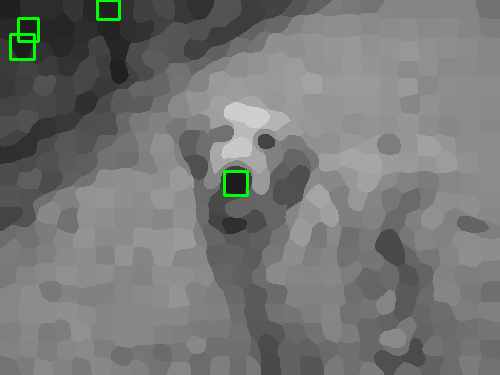

TypeError: ignored

In [0]:
image = cv2.imread("/content/drive/My Drive/best_boi-stanford-581.jpg")
compute(image, eyes_criteria=False)

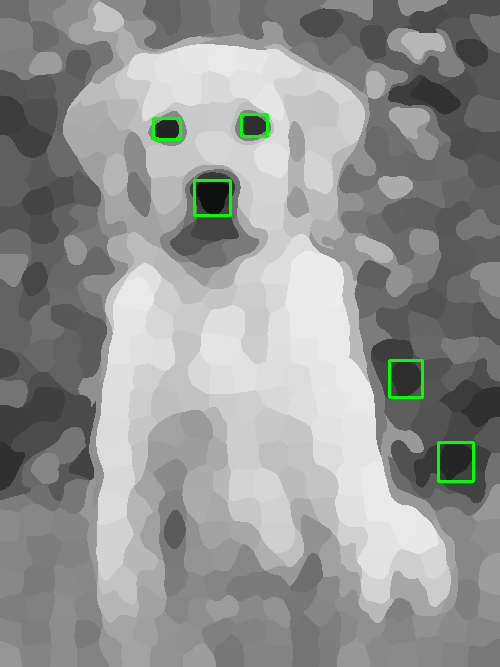

Nose found in region 134


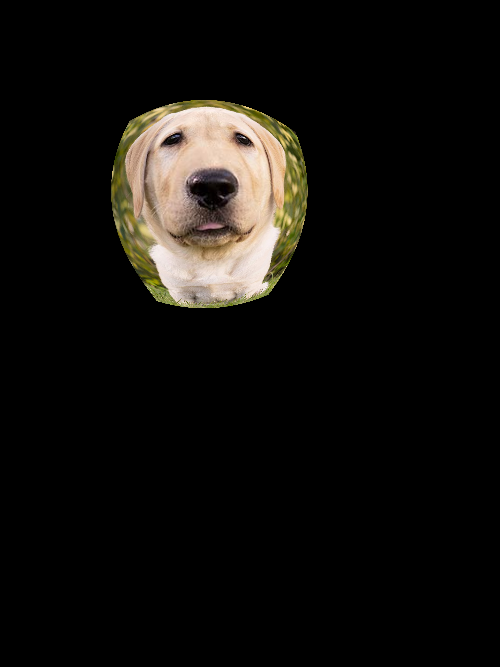

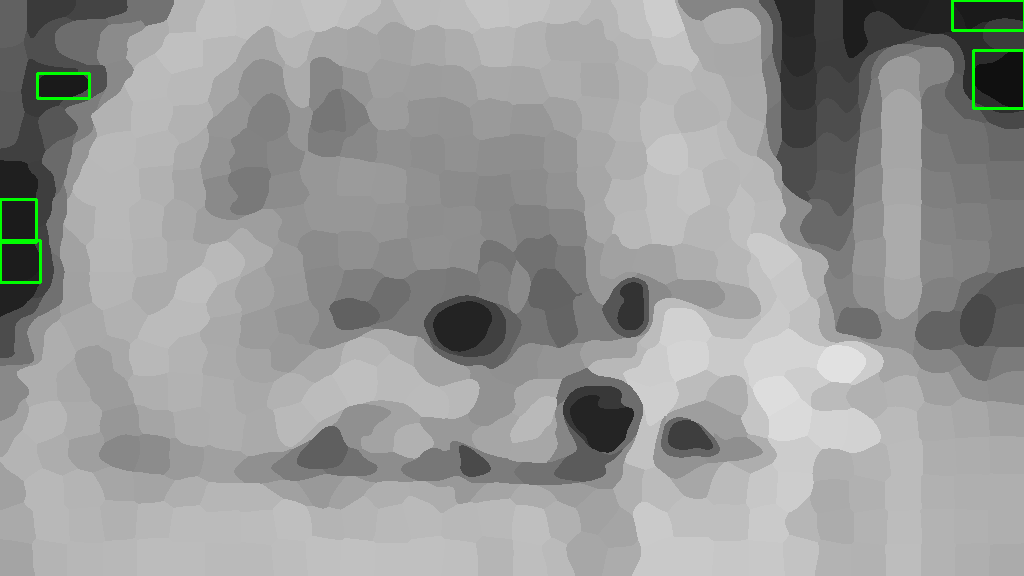

Nose found in region 60


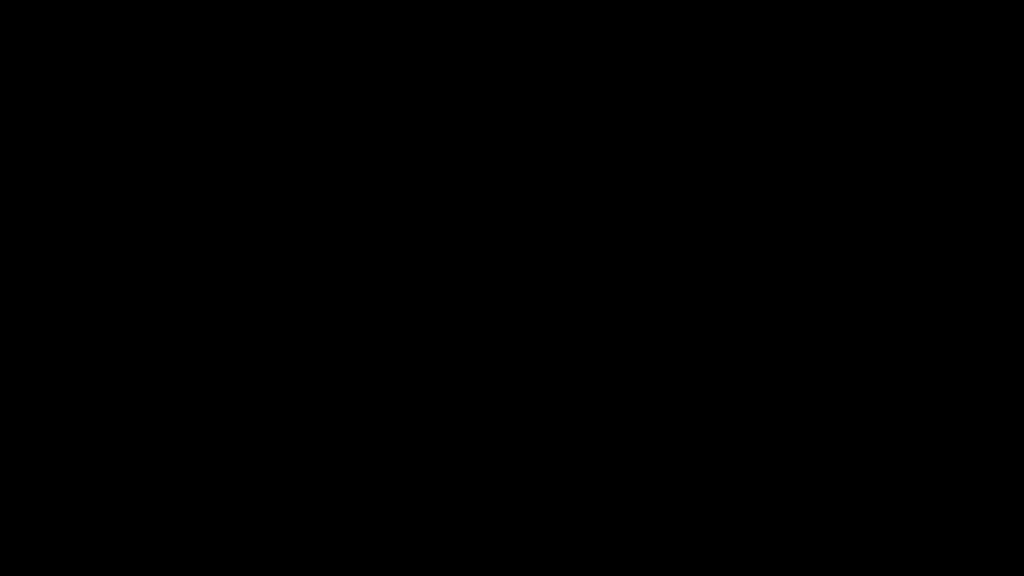

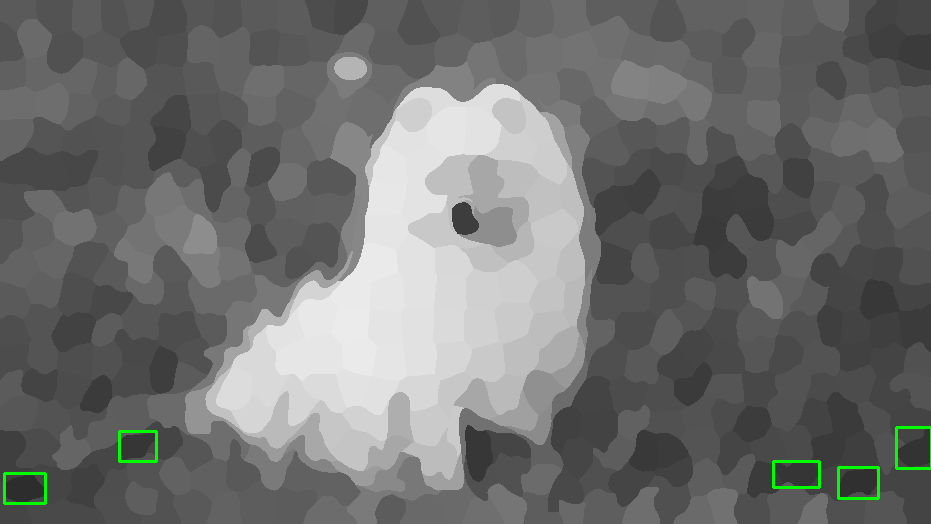

Nose found in region 463


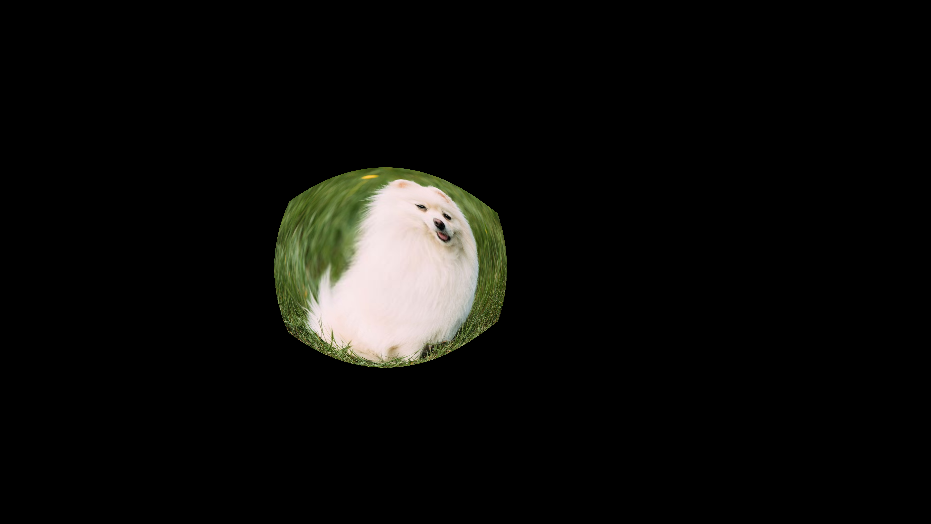

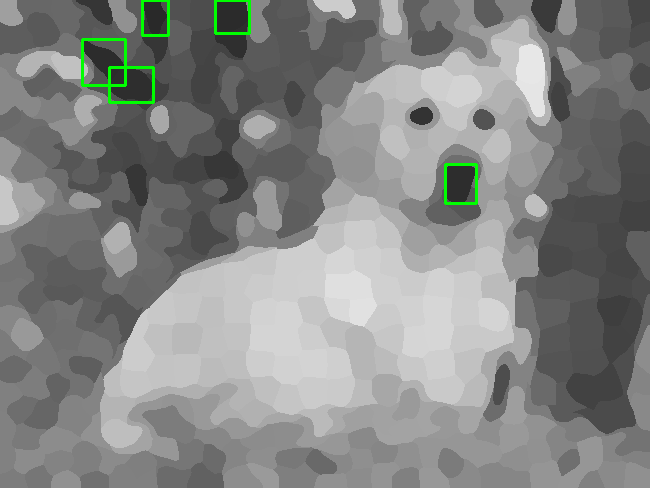

This doggo is missing a nose...


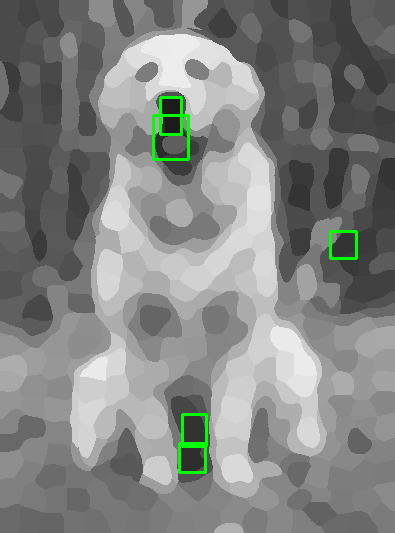

Nose found in region 96


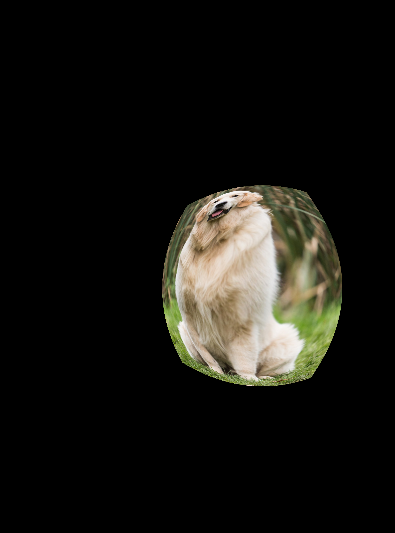

In [0]:
for i in range(1, 6):
  image = cv2.imread("/content/drive/My Drive/dog_pic{}.jpg".format(i))
  compute(image, eyes_criteria=False)

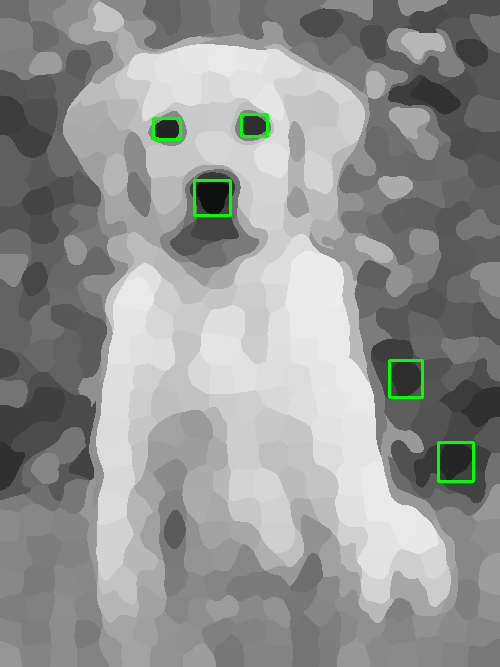

0.028948931571407373
Nose found in region 134


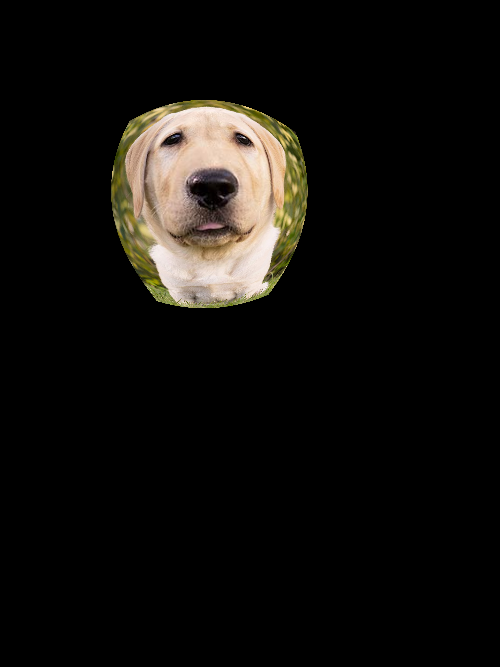

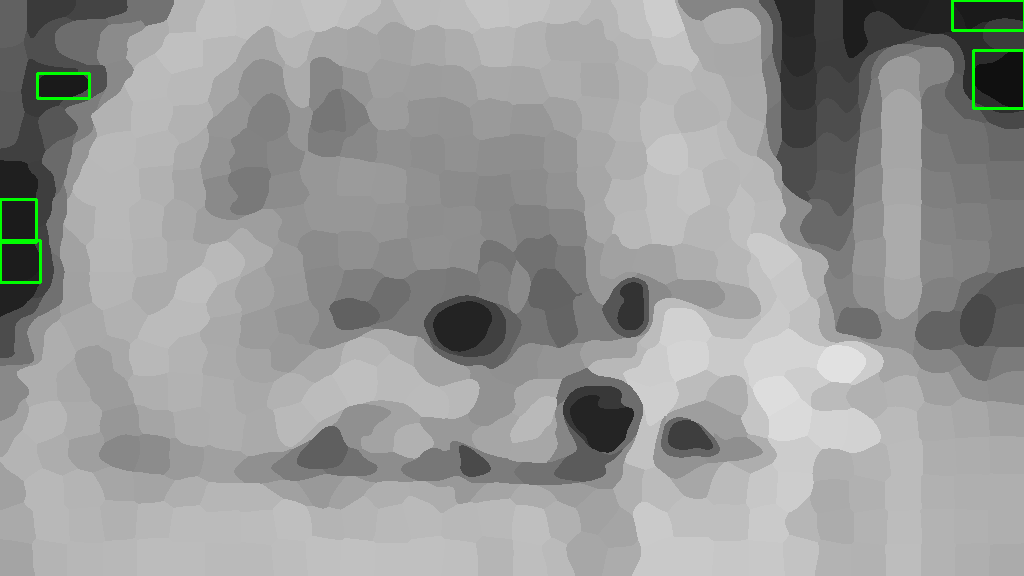

0.15425565739944852
0.15425565739944852
0.15425565739944852
This doggo is missing a nose...


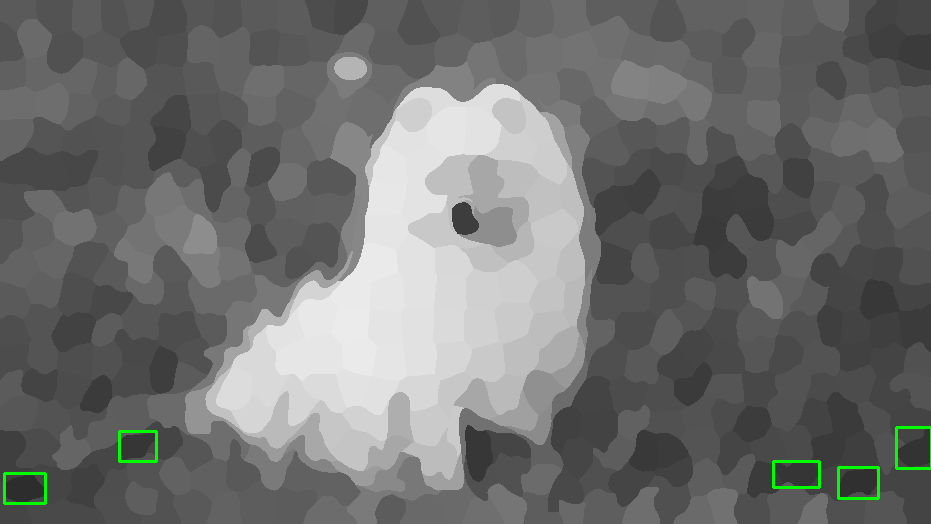

0.04652672655043676
Nose found in region 463


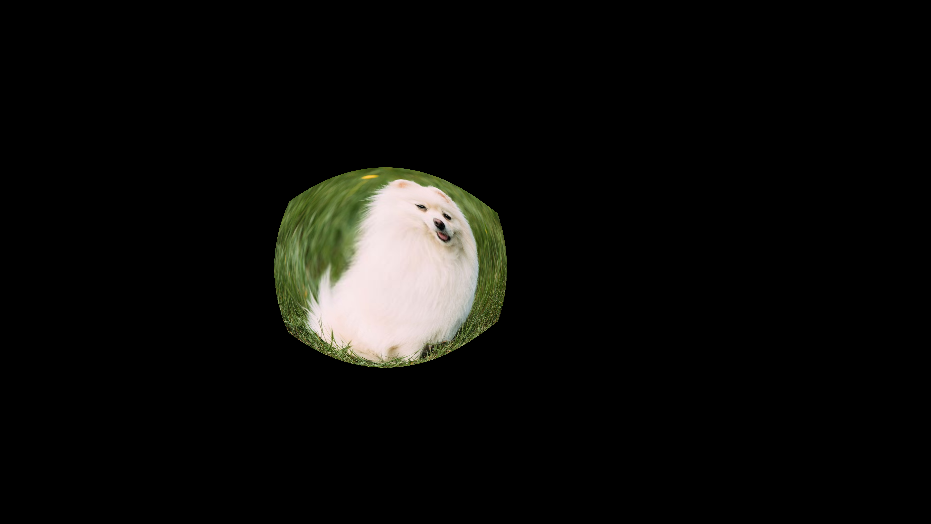

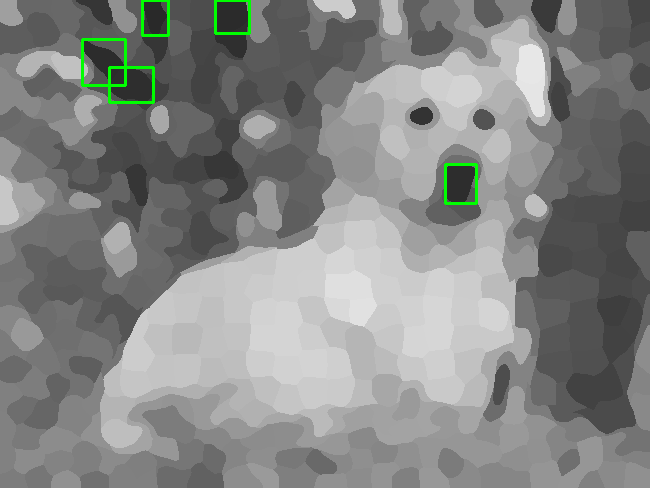

This doggo is missing a nose...


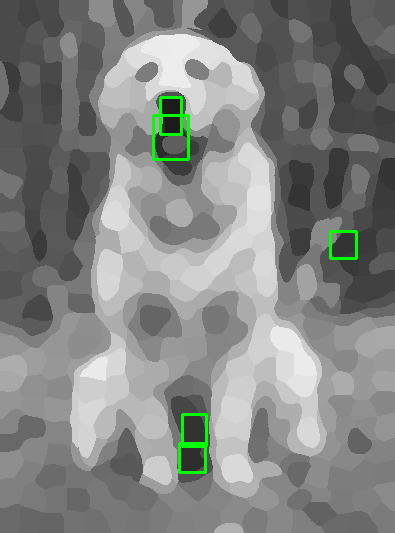

0.05994793457917704
0.05994793457917704
0.05994793457917704
0.1780706081319146
0.1780706081319146
This doggo is missing a nose...


In [0]:
for i in range(1, 6):
  image = cv2.imread("/content/drive/My Drive/dog_pic{}.jpg".format(i))
  compute(image, eyes_criteria=True)

# Training our Own Cascade, using a cnn face detection model to label our data.

In [0]:
import dlib
import cv2
detector = dlib.cnn_face_detection_model_v1('/content/drive/My Drive/dogHeadDetector.dat')


mmod_rectangles[[(179, 88) (297, 206)]]
Detection 0: Left: 179 Top: 88 Right: 297 Bottom: 206 Confidence: 1.0590267181396484


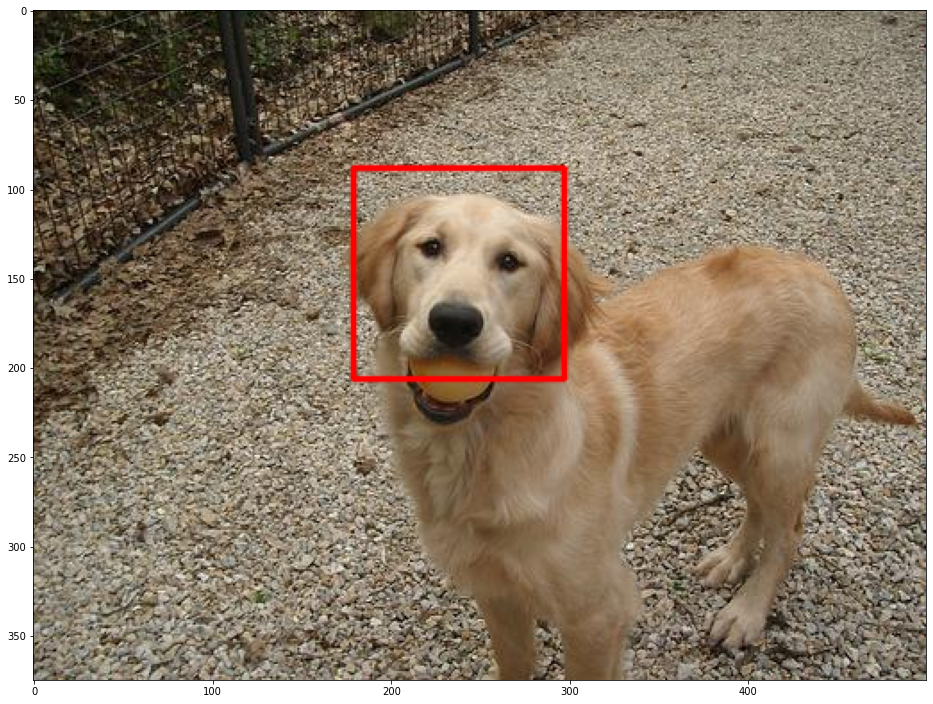

In [0]:
image_path = "/content/drive/My Drive/best_boi-stanford-581.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dets = detector(img, upsample_num_times=1)

print(dets)

img_result = img.copy()

for i, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))

    x1, y1 = d.rect.left(), d.rect.top()
    x2, y2 = d.rect.right(), d.rect.bottom()

    cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)
    
plt.figure(figsize=(16, 16))
plt.imshow(img_result)

In [0]:
import dlib
import cv2
detector = dlib.cnn_face_detection_model_v1('/content/drive/My Drive/dogHeadDetector.dat')

from os import listdir
from os.path import isfile, join
mypath = "/content/drive/My Drive/raw_data/meme_breeds/pos"
list_of_images = [f for f in listdir(mypath) if isfile(join(mypath, f))]
info_list = []
files_seen = set()
scoring = []
dog_cascade = cv2.CascadeClassifier('/content/drive/My Drive/raw_data/meme_breeds/data/cascade.xml')
f = open("/content/drive/My Drive/raw_data/meme_breeds/dog.info",'w')
for k,img_path in enumerate(list_of_images):
  try:
    if not (img_path in files_seen):
      img = cv2.imread(join(mypath, img_path))
      x,y,z = img.shape
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      dets = detector(img, upsample_num_times=1)
      info = ['pos/'+img_path,len(dets)]
      for i, d in enumerate(dets):
          x1, y1 = d.rect.left(), d.rect.top()
          x2, y2 = d.rect.right(), d.rect.bottom()
          info += [max(x1,0), max(y1,0),min(x2,x), min(y2,y)]
      
          # this function returns tuple rectangle starting coordinates x,y, width, height
          dogs = dog_cascade.detectMultiScale( img,scaleFactor=1.05, minNeighbors=20)
          #print(cats_ext)
          maxi = 0
          # draw a blue rectangle on the image
          for (x,y,w,h) in dogs:

            if (x1<=x<=x2 and y1<=y<=y2) or (x1<=x<=x2 and y1<=y+h<=y2) or (x1<=x+w<=x2 and y1<=y+h<=y2) or (x1<=x+w<=x2 and y1<=y<=y2): 

              score = (max((min(x2,x+w)-max(x,x1)),0)*(min(y2,y+h)-max(y,y1))) / ((x2-x1)*(y2-y1))
              maxi = max(score,maxi)
          scoring += [maxi]
  except RuntimeError:
    pass

In [0]:
import seaborn
from collections import Counter

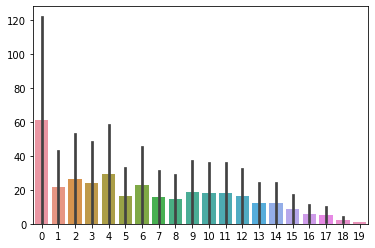

In [0]:
seaborn.barplot(data=[(x,y) for x,y in Counter([x//0.05*0.05 for x in scoring]).items()])

In [0]:
def process_image(img):
    img_output = img.copy()

    # convery to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # this function returns tuple rectangle starting coordinates x,y, width, height
    dogs = dog_cascade.detectMultiScale( gray,scaleFactor=1.05, minNeighbors=20)
    #print(cats_ext)
    
    # draw a blue rectangle on the image
    for (x,y,w,h) in dogs:
        img_output = cv2.rectangle(img_output,(x,y),(x+w,y+h),(255,0,0),2)       
    
    return img_output

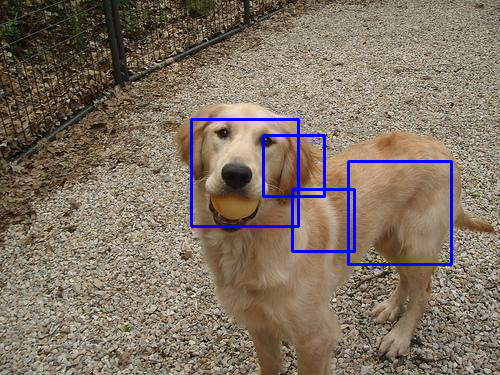

In [0]:
image_path = "/content/drive/My Drive/raw_data/meme_breeds/pos/best_boi-stanford-581.jpg"
img = cv2.imread(image_path)
t = process_image(img)
cv2_imshow(t)

In [0]:
%cd "/content/drive/My Drive/raw_data/meme_breeds/"

/content/drive/My Drive/raw_data/meme_breeds


In [0]:
! opencv_createsamples -num 775 -w 30 -h 30 -vec dog.vec -info dog.info


Info file name: dog.info
Img file name: (NULL)
Vec file name: dog.vec
BG  file name: (NULL)
Num: 775
BG color: 0
BG threshold: 80
Invert: FALSE
Max intensity deviation: 40
Max x angle: 1.1
Max y angle: 1.1
Max z angle: 0.5
Show samples: FALSE
Width: 30
Height: 30
Max Scale: -1
Create training samples from images collection...
dog.info(794) : parse errorDone. Created 716 samples


In [0]:
! opencv_traincascade -data data -vec dog.vec -bg bg.txt -numPos 600 -numNeg 600 -numStages 100 -w 30 -h 30 -featureType LBP -maxFalseAlarmRate 0.05 -minHitRate 0.9995

---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: data
vecFileName: dog.vec
bgFileName: bg.txt
numPos: 600
numNeg: 600
numStages: 100
precalcValBufSize[Mb] : 1024
precalcIdxBufSize[Mb] : 1024
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: LBP
sampleWidth: 25
sampleHeight: 25
boostType: GAB
minHitRate: 0.995
maxFalseAlarmRate: 0.1
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
Number of unique features given windowSize [30,30] : 10000

Stages 0-15 are loaded

===== TRAINING 16-stage =====
<BEGIN
OpenCV Error: Assertion failed (_img.rows * _img.cols == vecSize) in get, file /build/opencv-L2vuMj/opencv-3.2.0+dfsg/apps/traincascade/imagestorage.cpp, line 153
terminate called after t